In [2]:
import shapefile
import numpy as np

import vtk
import pyvista

# sklearn's KDTree is fast: use it if available
# Scipy also also a good KDTree
from sklearn.neighbors import KDTree as Tree

In [9]:
# Define conveinance functions for converting shape files to VTK objects

def _fix_to_topography(topo_points, points_to_update, static=20.0):
    """Update the z component of points to force them to lie on a topo surface"""
    tree = Tree(topo_points)
    ind = tree.query(points_to_update, k=1)[1].ravel()
    # Now update the elevation to be on the topo surface
    # Also shift it so its always just above the surface and not in the surface
    points_to_update[:,2] = topo_points[:,2][ind] + static
    return points_to_update

def _makeLineCell(idx0, idx1):
    """Create a vtkLine cell"""
    aLine = vtk.vtkLine()
    aLine.GetPointIds().SetId(0, idx0)
    aLine.GetPointIds().SetId(1, idx1)
    return aLine

def polygon_to_vtk(polygon, topo_points=None):
    """Converts a polygon shape to a vista.PolyData object.
    This assumes the points are ordered.
    """
    pts = np.array(polygon.points)
    pts = np.c_[pts, np.zeros(pts.shape[0])]
    if topo_points is not None:
        pts = _fix_to_topography(topo_points, pts)
        
    cells = vtk.vtkCellArray()
    for i in range(pts.shape[0]-1):
        cell = _makeLineCell(i, i+1)
        cells.InsertNextCell(cell)
    
    # Add in last connection to make complete polygon
    cell = _makeLineCell(i, 0)
    cells.InsertNextCell(cell)
    
    # Build the output
    pdo = vtk.vtkPolyData()
    pdo.SetPoints(pyvista.vtk_points(pts))
    pdo.SetLines(cells)
    return pyvista.wrap(pdo)

VTK_CONVERTERS = {
    shapefile.POLYGON: polygon_to_vtk,
}

def read_shape_file_to_vtk(filename, topo_points=None):
    """Read all the features of a shapefile into vista objects.
    Use the topo_points argument to fill the Z component of 2D points
    """
    shp = shapefile.Reader(filename)
    output = pyvista.MultiBlock()
    for i, feature in enumerate(shp.shapeRecords()):
        shape = feature.shape
        print(feature.record[1])
        try:
            try:
                output[i, feature.record[1]] = VTK_CONVERTERS[shape.shapeType](shape, topo_points)
            except:
                output[i] = VTK_CONVERTERS[shape.shapeType](shape, topo_points)
            return output
        except KeyError:
            raise RuntimeError('Shape type ({}) unknown'.format(shape.shapeType))
    return output

In [10]:
filename = './data/shapefiles/outline'
shapes = read_shape_file_to_vtk(filename)
shapes

FORGE site


MultiBlock (0x1d3f1fd9768)
  N Blocks:	1
  X Bounds:	332852.630, 336116.847
  Y Bounds:	4261250.737, 4264610.018
  Z Bounds:	0.000, 0.000

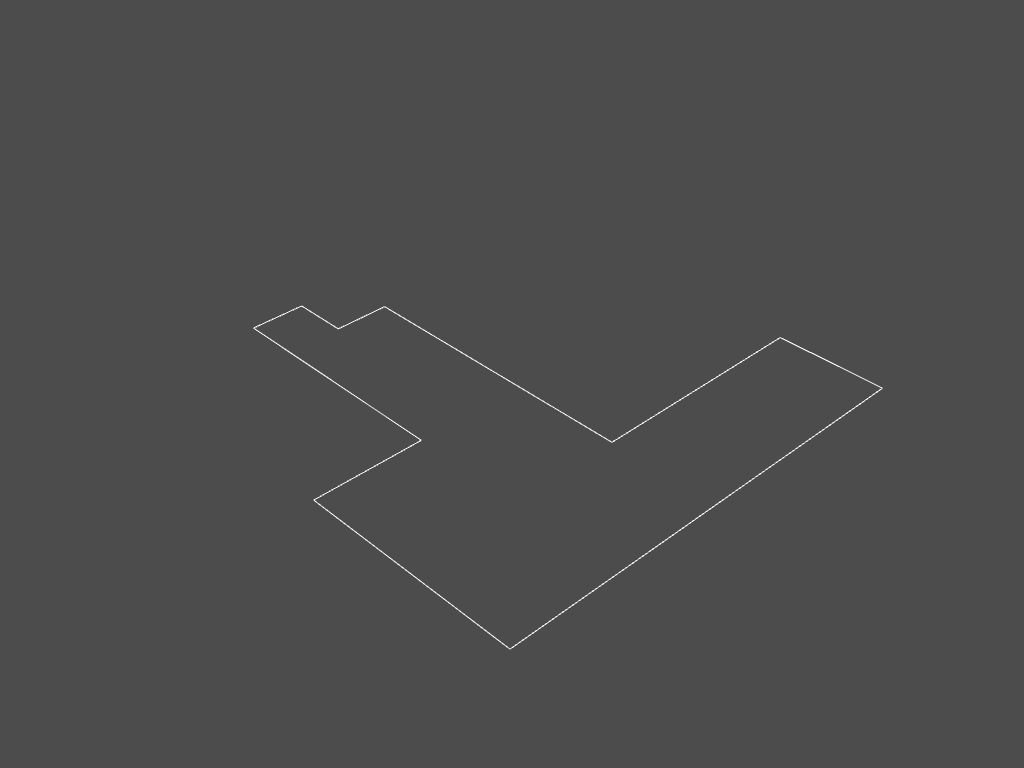

In [11]:
shapes.plot()